# Validator statistics for the Medalla testnet
This notebook contains some statistics/graphs compiled for validators running the final long-running eth2 phase 0 multi-client beacon chain testnet, Medalla.

The data used is taken from a database dump, kindly shared by Jim McDonald (@jgm), which includes beacon chain data for the first approxiamtely 12,000 epochs. The schemas for the tables in this database are included in the separate "schemas" file. Jim has made his `chaind` process for extracting beacon chain data from an ETH2 client [available for use](https://github.com/wealdtech/chaind), so the results in this notebook can be replicated by first generating a database from `chaind`.*

Special thanks also to Ben Edgington (@benjaminion_xyz) whose [Eth2 Annontated Spec](https://benjaminion.xyz/eth2-annotated-spec/phase0/beacon-chain/) has been a vital resource in understanding how the beacon chain works.

As part of the [Medalla data challenge](https://ethereum.org/en/eth2/get-involved/medalla-data-challenge/), this analysis will aim to extract insights about validator performance to inform future decisions about the eth2 rollout.

## Attestations
In this notebook, validator performance is based entirely on how many of their _attestations_ make it into the beacon chain, and how quickly. As a quick introduction for anyone unfamiliar, attestations are effectively votes by validators, who vouch for the correctness of a block they have seen. These attestations are themselves aggregated into blocks which in turn are voted on by the validators. Blocks which get enough votes (ultimately at least $2/3$ of the whole validator set) are finalised by the CasperFFG finality overlay. Finalised blocks may be described as _canonical_.

In [7]:
# imports
import psycopg2
import math
import time
import matplotlib.pyplot as plt
import pandas as pd

from chaindtools import *

In [8]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [13]:
# basic info about the dataset
cursor.execute("SELECT MAX(f_slot) FROM t_attestations")
latest_slot = cursor.fetchone()[0]
n_epochs = latest_slot // 32 + 1
print(f"latest attested slot: {latest_slot}, latest epoch: {n_epochs - 1}")
cursor.execute("SELECT f_slot, f_root FROM t_blocks ORDER BY f_slot DESC LIMIT 1")
latest_block = cursor.fetchone()
last_block_slot, root = latest_block[0], latest_block[1].hex()
print(f"latest block root: {root}")

latest attested slot: 468456, latest epoch: 14639
latest block root: bb195c6772635919653395614b2fc2d46d94e2047322b2e4f30e41c7bee115cc


In [14]:
# identify canonical blocks

start_time = time.time()

# block bb195c6772635919653395614b2fc2d46d94e2047322b2e4f30e41c7bee115cc indicated as finalised on beaconcha.in.
# consider all ancestors of this block to be canonical.

cursor.execute("ALTER TABLE t_blocks DROP COLUMN IF EXISTS f_canonical")
cursor.execute("ALTER TABLE t_blocks ADD COLUMN f_canonical BOOLEAN DEFAULT false")

while True:
    cursor.execute(f"UPDATE t_blocks SET f_canonical = true WHERE f_root = '\\x{root}'")
    cursor.execute(f"SELECT f_slot, f_parent_root FROM t_blocks WHERE f_root = '\\x{root}'")
    result = cursor.fetchone()
    if not result:
        print(child_slot, child_root)
        print(slot,root)
        break
    child_slot, child_root = slot, root
    slot, root = result[0], result[1].hex()
    if slot % 32 == 0:
        seconds = time.time() - start_time
        elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
        done = (1 - (slot+1) / (last_block_slot+1))
        left = time.strftime("%H:%M:%S",time.gmtime(seconds * (1 / done - 1)))
        print(f"Working backwards through blocks. Current slot: {slot} ({100*done:.2f}% complete). "
              f"{elapsed} elapsed. {left} left.", end='\r')

connection.commit()
print(f"completed in {elapsed}." + ' ' * 85)

438396 492484a0de61f10495cfa837f5584adf88ffb01bea2bbc8b57e0ac61650c1167. 00:00:03 elapsed. 00:00:53 left.
438395 f520f7df6fe23f87f06af4431d567932d960c10ae75bb03f8d582f76ba95e425
completed in 00:00:03.                                                                                     


In [17]:
cursor.execute(f"SELECT f_slot, f_parent_root FROM t_blocks WHERE f_root = '\\x{child_root}'")
result = cursor.fetchone()
print(result)
cursor.execute(f"SELECT f_slot, f_parent_root FROM t_blocks WHERE f_root = '\\x{root}'")
result = cursor.fetchone()
print(result)
cursor.execute(f"SELECT f_root FROM t_blocks WHERE f_slot = 438394")
result = cursor.fetchall()
print(result)

(438395, <memory at 0x7f9d5a1e2dc0>)
None
[]


## Attestation performance
First we define a function which will extract atestation information from the database and reduce it to a form suitable for performance analytics. Attestations are aggregated by groups of validators ("committees") who are nominated in advance by the beacon chain. For every slot* there will be at least one committee (usually many) submitting aggregated attestations. To examine the performance of validators individually therefore, we need to disaggregate the attestatons. Every validator is nominated to attest once every _epoch_ (32 slots).

To decode the attesttions, we need to get the list of validators for each committee, at each slot, and then match the _aggregation bits_ from the attestation to the relevant committee. The aggregation bits can be thought of as a series of boolean flags indicating whether each validator in the committee submitted their individual attestation to be aggregated.

Because peer-to-peer networking can be messy, ultimately different versions of aggregated attestations end up being included in the beacon chain, at different slots. How many slots after the the block being attested a validator manages to get their attestation included may be thought of as measure of their performance - the sooner the attestation is included, the better (validator rewards also recognise this). This measure of performance on an individual attestation is called _inclusion distance_ where an inclusion distance of 0 indicates the attestation was included at the very next slot, and an inclusion distance of 1 is the slot after (etc.). If the validator does not have an attestation included at all, the attestation is said to be _missed_, denoted by an inclusion distance of -1.

The function defined in `attestations.py` (imported above) returns just the _minimum_ inclusion distance for every validator which was part of a committee for the requested slot.

\* a slot, at 12 seconds long, is the basic unit of time on the beacon chain. Every slot may or may not contain a single block.

## Validators
Next, we extract information about each validator in the dataset from the `t_validators` table into a `dict` for easier access. The numbers below have the following meanings:

| Database name | Dict name | Meaning |
| :- | :- | :- | 
| `f_index` | [index] | The validator index. Every validator that enters the system is consecutively assigned a unique validator index number. |
| `f_activation_eligibility_epoch` | `activation_eligibility_epoch` | This is the epoch by which this validator has had its Ether deposit procesed from the eth1 chain. |
| `f_activation_epoch` | `activation_epoch` | The epoch at which this validator was first nominated for attestation duties. If there is a large number of validators entering the set, this may be some time after `activation_eligibility_epoch` as new validators are only allowed in gradually and must wait in a queue in the meantime. |
| `f_exit_epoch` | `exit_epoch` | The epoch at which this validator left the validator set, either because they voluntarily withdrew, or their balance leaked below the minimum for participation (16 ETH), or because they were slashed for contradicting themselves. |
| n/a | `first_attestation` | The first attestation by this validator found in this dataset. |
| n/a | `latest_attestation` | The most recent attestation by this validator found in this dataset. |
| n/a | `client` | The name of the client run by this validator (will be estimated from block graffiti) |

In [5]:
# get info about validators

query = """SELECT f_index, f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed
           FROM t_validators"""
cursor.execute(query)
result = cursor.fetchall()
validators = {r[0]: {"activation_eligibility_epoch": r[1],
                     "activation_epoch": r[2],
                     "exit_epoch": r[3],
                     "slashed": r[4],
                     "first_attestation":  -1,
                     "latest_attestation": -1} for r in result}

## Validator status
Let's use the information we've leared about the validators so far to get a basic picture how the makeup of the validator set has varied over the period covered by the data. At each epoch we can categorise validators into four types:
1. **active**: validators who are required to produce an attestation each epoch
2. **waiting**: validators who have had their deposits from the ETH1 chain processed, and are in a queue to join the active validator set
3. **exited**: validators who have left the validator set, either because they made a voluntary withdrawal, or because their balance leaked through inactivity to the point where they were ejected from the validator set (this happens if the balance drops below 16 ETH)
4. **slashed**: validators who were ejected from the validator set for breaking protocol rules (e.g. contradicting themselves by attesting to multiple blocks for the same slot)

From the chart below, we can see at genesis that the entire validator set is composed of *active* validators, and that throughout the period the active validator set appears to grow linearly as the queue of new validators is processed. The exception is a short period around epoch 3000 when the validator queue (represented in orange) was emptied and the active set stopped growing. This is most likely due to the [roughtime incident](https://medium.com/prysmatic-labs/eth2-medalla-testnet-incident-f7fbc3cc934a). One explanation is that as the network suffered a widely-publicised period of non-finalisation and uncertainty, new validators stopped making deposits to join the network, so once those who had already had their deposits processed joined the active set, there were no new validators joining the queue. A more concerning explanation would be if the incident had somehow caused the network to stop processing new deposts from the ETH1 chain, but I have seen no evidence that this is the case.

The other two categories — exited and slashed validators — show up as tiny slivers that are barely visible. This is good news, as it suggests that there were no serious client bugs causing validators to commit slashable offences. Despite some concerns that perhaps the [majority of Prysm nodes would be slashed](https://twitter.com/terencechain/status/1294637848029585409?s=20) after the roughtime incident, it seems that only those who committed deliberate slashable offences to test the system, and possibly a few unfortunate souls who quickly switched clients, were slashed.

In [6]:
# look at validator status - waiting, active, exited, slashed
start_time = time.time()

waiting_count = [0] * n_epochs
active_count  = [0] * n_epochs
slashed_count = [0] * n_epochs
exited_count  = [0] * n_epochs

for epoch in range(n_epochs):
    for _, validator in validators.items():
        if epoch >= validator["activation_eligibility_epoch"] and epoch < validator["activation_epoch"]:
            waiting_count[epoch] += 1
        elif validator["exit_epoch"] != -1 and epoch >= validator["exit_epoch"] :
            if validator["slashed"]:
                slashed_count[epoch] += 1
            else:
                exited_count[epoch] += 1
        elif epoch >= validator["activation_epoch"]:
            active_count[epoch] += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((n_epochs) / (epoch+1)-1)))
    percentage = 100*(epoch+1)/n_epochs
    print(f"Epoch {epoch} of {n_epochs-1} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')

print(f"Completed in {elapsed}." + ' ' * 50)
            
            
status_data = pd.DataFrame({'waiting': waiting_count, 'active': active_count, 'exited': exited_count,
                            'slashed': slashed_count})

Completed in 00:03:59.                                                  


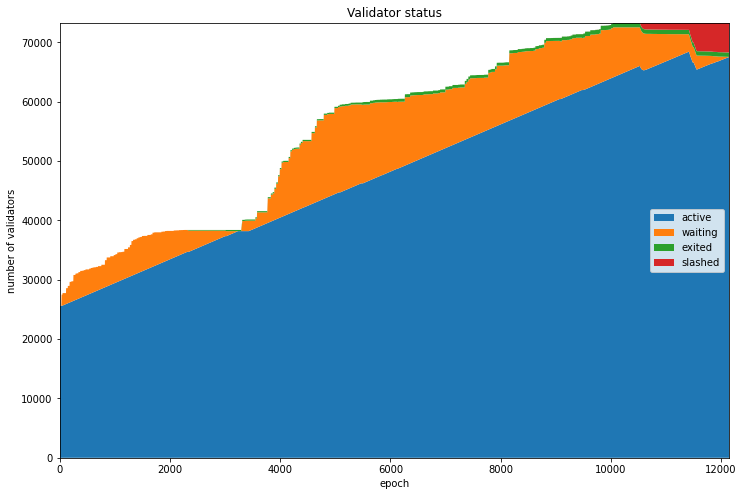

In [7]:
# draw validator status stacked area plot
fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(status_data.index)), status_data['active'], status_data['waiting'],
              status_data['exited'], status_data['slashed'],labels=['active','waiting','exited','slashed'])
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Validator status')
plt.xlabel('epoch')
plt.ylabel('number of validators')
plt.show()

## First pass through attestations
To fill in the `first_attestation` and `latest_attestation` fields of the validator lookup table above, we need to run through all the attestations in the dataset. This information will be useful later when we try to discover different reasons for validators failing to get attestations included in the beacon chain.

In [8]:
# first pass through attestations: identify first and latest attestations for each validator

start_time = time.time()

for slot in range(latest_slot+1):
    validator_scores, _ = attestation_performance(cursor, slot)
    epoch = slot // 32
    for validator_index in validator_scores:
        inclusion_distance = validator_scores[validator_index]
        if inclusion_distance != -1:
            validators[validator_index]["latest_attestation"] = slot
            if validators[validator_index]["first_attestation"] == -1:
                validators[validator_index]["first_attestation"] = slot
    
    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
    percentage = 100*(slot+1)/(latest_slot+1)
    print(f"First pass: epoch {epoch} of {latest_slot//32} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')

print(f"First pass completed in {elapsed}." + ' ' * 50)

First pass completed in 00:50:27.                                                  


## Second pass through attestations
We'll now look at whether each validator managed to attest successfully, and have their attestations included into the canonical chain. As mentioned previously this information is contained in the `aggregation_bits` of the attestations. If their attestations were included, we can calculate how long it took (the *inclusion distance* mentioned above). If their attestations weren't included, we can use the information from `first_attestation` and `latest_attestation` to have a guess at *why* the attestation was missed. We use the following definitions:
1. `success_count`: the number of attestations in the epoch that where successfully included in the canonical chain
2. `absent_count` : the number of scheduled attestations from validators who did not have any successful attestations in the whole dataset — we think of these validators as *absent* because they never showed up at all
3. `dormant_count`: the number of scheduled attestations from validators who have not *yet* made a successful attestations (but they did later in the dataset) — we think of these as *dormant* validators who were not ready to attest when their `activation_epoch` hit (perhaps they overslept?)
4. `abandoned_count`: the number of scheduled attestations from validators who have no later successful attestations in the dataset (these are perhaps validators who lost interest in the testnet and simply *abandoned* their validator(s) without initiating the proper exit procedure)
5. `missed_count`: any other scheduled attestations which were not made each epoch.

As stated above these categories are all just guesses, based on each validator's behaviour. These categorisations are partly based on the assumption that with no real value at stake on the Medalla testnet, some people will make deposits for validators that they never bother to fire up (*absent*), some may not prepare in advance of activation and therefore be late (*dormant*), and still others may not bother to pick up their validator if it falls over, or they have no further interest in participating (*abandoned*).

This is not meant pejoratively! My own validator would show up as *dormant* for a few epochs, since I hadn't factored in the time needed to compile and run the Lighthouse beacon chain client before Medalla's genesis time (**blushes**). Rather it is an illustration of the difficulty inherent in trying to test an economically driven consensus/finality mechanism without economic incentives.

As well as calculating rates of included/missed attestations, we will also look at the *mean inclusion distance* for those attestations that were successful, which makes another useful metric of network performance.

In [10]:
# second pass through attestations: calculate participation rates and mean inclusion distance
# if the attestation is missed and the validator has not yet done any attestations, it is considered dormant
# if the attestation is missed and there are no future attestations, it is considered abandoned

start_time = time.time()

empty = [0] * n_epochs
success_count   = empty.copy()
absent_count    = empty.copy()
dormant_count   = empty.copy()
abandoned_count = empty.copy()
missed_count    = empty.copy()
sum_distance    = empty.copy()
sum_ae          = empty.copy()

for slot in range(latest_slot+1):
    validator_scores, validator_ae = attestation_performance(cursor, slot)
    epoch = slot // 32
    for validator_index in validator_scores:
        if validator_scores[validator_index] != -1:
            success_count[epoch]   += 1
            sum_distance[epoch]    += validator_scores[validator_index]
            sum_ae[epoch]          += validator_ae[validator_index]
        elif validators[validator_index]["latest_attestation"] == -1:
            absent_count[epoch]    += 1
        elif slot < validators[validator_index]["first_attestation"]:
            dormant_count[epoch]   += 1
        elif slot > validators[validator_index]["latest_attestation"]:
            abandoned_count[epoch] += 1
        else:
            missed_count[epoch]    += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
    percentage = 100*(slot+1)/(latest_slot+1)
    print(f"Second pass: epoch {epoch} of {latest_slot//32} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')

mean_inclusion_distance = [sum_distance[e] / success_count[e] if success_count[e] > 0 else None
                           for e in range(n_epochs)]

mean_ae = [100 * sum_ae[e] / (success_count[e] + missed_count[e]) if success_count[e] > 0 else 0
           for e in range(n_epochs)]

print(f"Second pass completed in {elapsed}." + ' ' * 50)

Second pass completed in 00:45:53.                                                  


## Participation rate statistics
Using the categories defined above, we can now take a look at how the network performed, in terms of the percentage of validators who successfully attested each epoch (the *participation rate*). Remembering that for finality on the beacon chain, at least $2/3$ of validators must successfully attest each epoch, we're particularly interested in how much time the network stays above this level. From the participation stats below, we can see that over 88% of epochs reached this threshold — from the histogram we can see that most epochs were clustered close to the 80% mark.

More interesting is the stacked validator participation chart below. This shows a fairly consistent slice of the validator set was composed of absent validators who deposited but never participated (in purple). The dormant slice (green) varied more, and interestingly we can see little ramps where a series of new validators joined and were dormant for some time. This could just be testnet whales joining with hundreds of validators without being ready. However, this could also be an interesting way of spotting network problems client bugs preventing users from joining, and merits looking into further. The number of dormant validators grows significantly during/after the roughtime incident, as new validators were unable to sync their clients to the beacon chain.

The slice of abandoned validators (red) grows gradually throughout the dataset, and shows a jump at the time of the roughtime incident. A large jump in abandoned validators around epoch 4500 is also of interest. This again could be a validator whale simply walking away from the network without making a clean exit, but it would be worth exploring any other possible causes.

The biggest feature of this chart is clearly the enormous growth in missed attestations (orange) which occurs during/after the roughtime incident and accounts for the vast majority of epochs where the participation rate was below 66%. The participation rate even drops to zero for at least one epoch, raising an interesting question about the security of the network at this point.

## Excluding the roughtime incident
For an idea of the general health of the network, I've rerun the statistics and plotted a new histogram over all epochs since epoch 5000, to exclude the roughtime incident. 99.9% of these epochs reached the threshold for finality, despite the presence of absent, dormant and abandoned validators. Accordingly the participation rate histogram clusters more closely around the high-70s.

Participation rate statistics by epoch

count    12148.000000
mean        72.066245
std         17.450533
min          0.000000
25%         74.365055
50%         77.400539
75%         79.084658
max         86.428814
Name: active, dtype: float64

Percentage of epochs over 2/3 participation rate: 90.7%


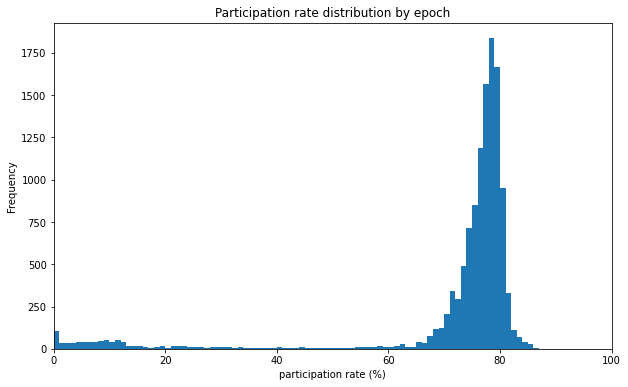

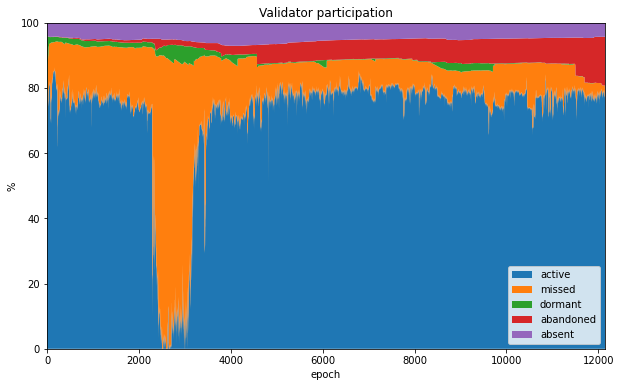

Participation rate statistics by epoch (epoch 5000 onwards)

count    7148.000000
mean       78.162449
std         2.364876
min        62.318087
25%        77.140787
50%        78.559300
75%        79.661713
max        85.462274
Name: active, dtype: float64

Percentage of epochs over 2/3 participation rate: 99.9%


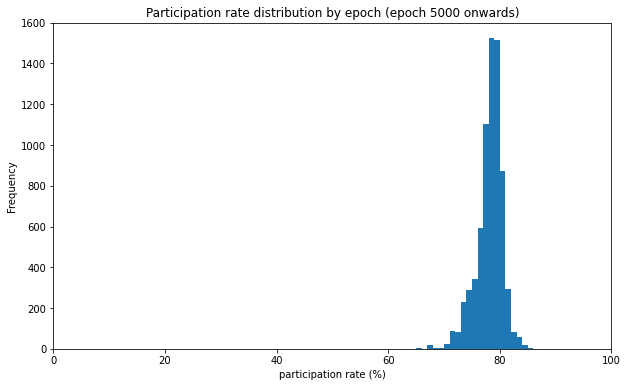

In [11]:
# participation rate statistics and stacked area plots

# what is the distribution of gap between validator activation and the first successful attestation?
# - for the genesis set, non-genesis validators, all validators?
# what proportion of all active validators have never had an attestation included?
# what does the participation rate look like if we exclude dormant, abandoned validators?
# what is the proportion of epochs with sub 2/3 

participation_data = pd.DataFrame({'active': success_count,
                                   'missed': missed_count,
                                   'absent': absent_count,
                                   'dormant': dormant_count,
                                   'abandoned': abandoned_count})

perc_participation_data = participation_data.divide(participation_data.sum(axis=1), axis=0) * 100

print("Participation rate statistics by epoch\n")
print(perc_participation_data['active'].describe(), end='\n\n')
quorate = 100 * len(perc_participation_data[perc_participation_data['active'] > 200/3]) / n_epochs
print(f"Percentage of epochs over 2/3 participation rate: {quorate:.1f}%")

fig=plt.figure(figsize=(10,6))
perc_participation_data['active'].plot.hist(bins=range(0,101))
plt.title('Participation rate distribution by epoch')
plt.xlabel('participation rate (%)')
plt.xlim(0,100)
plt.show()

fig=plt.figure(figsize=(10,6))
plt.stackplot(range(len(perc_participation_data.index)),
              perc_participation_data['active'],
              perc_participation_data['missed'],
              perc_participation_data['dormant'],
              perc_participation_data['abandoned'],
              perc_participation_data['absent'],
              labels=['active','missed','dormant','abandoned','absent'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Validator participation')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

print("Participation rate statistics by epoch (epoch 5000 onwards)\n")
active_5000 = perc_participation_data['active'].iloc[range(5000,n_epochs)]
print(active_5000.describe(), end='\n\n')
quorate = 100 * len(active_5000[active_5000 > 200/3]) / (n_epochs - 5000)
print(f"Percentage of epochs over 2/3 participation rate: {quorate:.1f}%")

fig=plt.figure(figsize=(10,6))
active_5000.plot.hist(bins=range(0,101))
plt.title('Participation rate distribution by epoch (epoch 5000 onwards)')
plt.xlabel('participation rate (%)')
plt.xlim(0,100)
plt.show()

## Excluding non-live validators
Using our previous categories for non-live validators (dormant, absent, abandoned) we can also take a look at what the network might look like without them. At an ETH price of USD 350, each validator will cost USD 11,200, so it seems unlikely that validators will be created on mainnet by ETH holders only to be ignored or abandoned, considering the captial cost, opportunity cost for missed earnings, and inactivity leakage cost for validators who fail to submit attestations. With this in mind, the very existence of these types of non-live validator is not expected, unless this validator behaviour is somehow caused by as-yet unidentified clent or protocol bugs.

The three graphs created above have been repeated, but this time only `success_count` and `missed_count` are used in the calculation of the participation rate. Now the mean participation rate jumps by 9-12 percentage points, reaching 90% with zero sub-$2/3$ particpation rates for epcohs from 5000 onwards.

Participation rate statistics by epoch (excluding non-live validators)

count    12148.000000
mean        81.615234
std         20.013103
min          0.000000
25%         82.088870
50%         87.903277
75%         90.444722
max        100.000000
Name: active, dtype: float64

Percentage of epochs over 2/3 participation rate: 91.9%


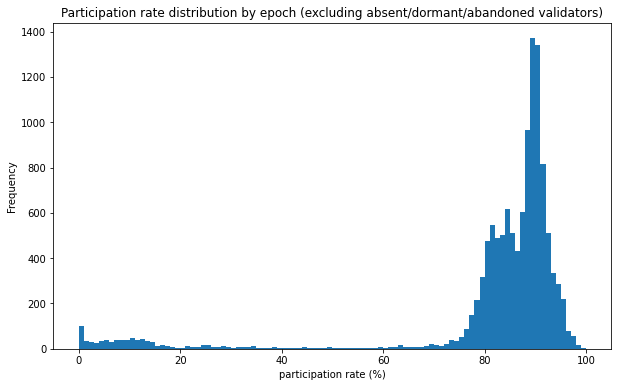

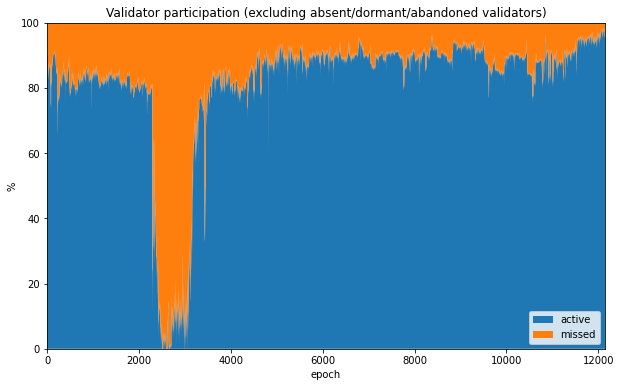

Participation rate statistics by epoch (excluding non-live validators, epoch 5000 onwards)

count    7148.000000
mean       89.914451
std         3.066638
min        74.604676
25%        88.427378
50%        89.970406
75%        91.555130
max       100.000000
Name: active, dtype: float64

Percentage of epochs over 2/3 participation rate: 100.0%


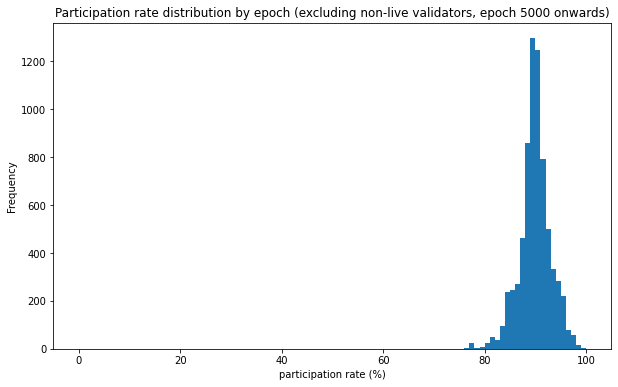

In [12]:
# participation rate statistics and stacked area plots (excluding non-live validators)

reduced_participation_data = pd.DataFrame({'active': success_count, 'missed': missed_count})

perc_reduced_participation_data = participation_data.divide(reduced_participation_data.sum(axis=1), axis=0) * 100


print("Participation rate statistics by epoch (excluding non-live validators)\n")
print(perc_reduced_participation_data['active'].describe(), end='\n\n')
quorate = 100 * len(perc_reduced_participation_data[perc_reduced_participation_data['active'] > 200/3]) / n_epochs
print(f"Percentage of epochs over 2/3 participation rate: {quorate:.1f}%")

fig=plt.figure(figsize=(10,6))
perc_reduced_participation_data['active'].plot.hist(bins=range(0,101))
plt.title('Participation rate distribution by epoch (excluding absent/dormant/abandoned validators)')
plt.xlabel('participation rate (%)')

fig=plt.figure(figsize=(10,6))
plt.stackplot(range(len(perc_reduced_participation_data.index)),
              perc_reduced_participation_data['active'],
              perc_reduced_participation_data['missed'],
              labels=['active','missed'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Validator participation (excluding absent/dormant/abandoned validators)')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

print("Participation rate statistics by epoch (excluding non-live validators, epoch 5000 onwards)\n")
active_5000 = perc_reduced_participation_data['active'].iloc[range(5000,n_epochs)]
print(active_5000.describe(), end='\n\n')
quorate = 100 * len(active_5000[active_5000 > 200/3]) / (n_epochs - 5000)
print(f"Percentage of epochs over 2/3 participation rate: {quorate:.1f}%")

fig=plt.figure(figsize=(10,6))
active_5000.plot.hist(bins=range(0,101))
plt.title('Participation rate distribution by epoch (excluding non-live validators, epoch 5000 onwards)')
plt.xlabel('participation rate (%)')
plt.show()

## Mean inclusion distance
Another metric we can use to look at the health of the network is how quickly validators are able to have their attestations included into the beacon chain. As mentioned above, this is called the *inclusion distance*, which is the number of slots it takes for an attestatation to be included in a canonical block. By averaging this across all validators who successfully attested in a given epoch, we get a quantity called the *mean inclusion distance*. We already calculated this in the second pass through attestations above.

Unsurprisingly, the mean inclusion distance jumps significantly around the roughtime incident. But interestingly there are a number of smaller spikes. A particularly large spike around epoch 4800 for example (shown in greater detail in the second graph), which could be an indication of a networking problem or bug which merits closer attention.

Looking just at the period from epoch 5000 onwards, we can see the average (mean) of the mean inclusion distance is around 0.4, suggesting that the majority of successful attestations are included in the beacon chain with an inclusion distance of 0 (i.e. at the first opportunity).

Mean inclusion distance statistics

count    12084.000000
mean         1.172644
std          2.919571
min          0.000000
25%          0.304382
50%          0.415178
75%          0.586867
max         30.093750
Name: mean inclusion distance, dtype: float64



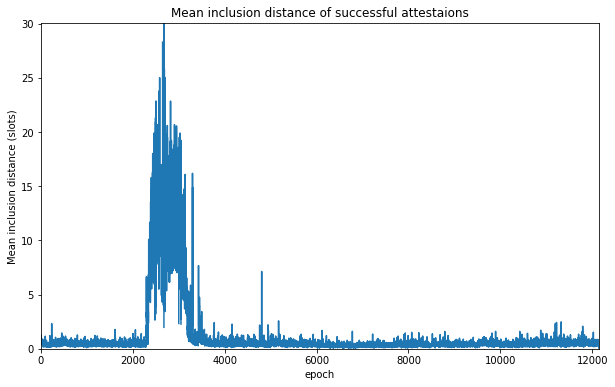

Mean inclusion distance statistics (epoch 5000 onwards)

count    7148.000000
mean        0.411257
std         0.199408
min         0.000000
25%         0.281162
50%         0.372451
75%         0.495822
max         2.576068
Name: mean inclusion distance, dtype: float64


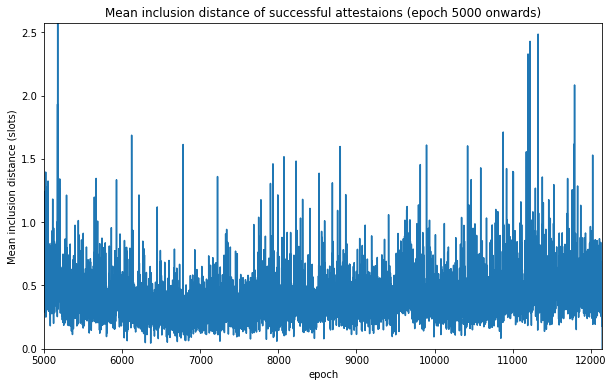

In [13]:
# graphs and stats for mean inclusion distance

mid_series = pd.Series(mean_inclusion_distance, name="mean inclusion distance")

print("Mean inclusion distance statistics\n")
print(mid_series.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(10,6))
plt.plot(mid_series)
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

print("Mean inclusion distance statistics (epoch 5000 onwards)\n")
print(mid_series.iloc[5000:].describe())

# plot the mean inclusion distance
fig=plt.figure(figsize=(10,6))
plt.plot(mid_series.iloc[5000:])
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

## Attestation Effectiveness
One metric that effectively combines participation rate and inclusion distance into a single score describing a validator's performance is *attestation effectiveness*, which has been defined by [Jim McDonald](https://www.attestant.io/posts/defining-attestation-effectiveness/) as the ratio between the maximum reward a validator could have received for full prompt participation, and the reward they actually received. The protocol penalises late attestations, scaling the attestation reward by the inverse of the inclusion distance.\*

\* For attestation effectiveness, the inclusion distance is measured from the first slot containing a valid block, since attestations will be delayed if a slot is empty, through no fault of the validator.

Mean attestation effectiveness statistics

count    12148.000000
mean        78.933597
std         21.039195
min          0.000000
25%         79.465787
50%         85.410811
75%         88.884325
max        100.000000
Name: mean attestation effectiveness, dtype: float64



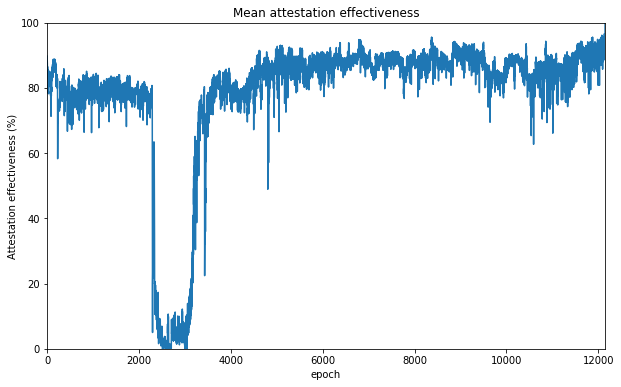

Mean inclusion distance statistics (epoch 5000 onwards)

count    7148.000000
mean       87.826771
std         3.384302
min        62.704468
25%        86.174844
50%        88.374243
75%        89.927956
max       100.000000
Name: mean attestation effectiveness, dtype: float64


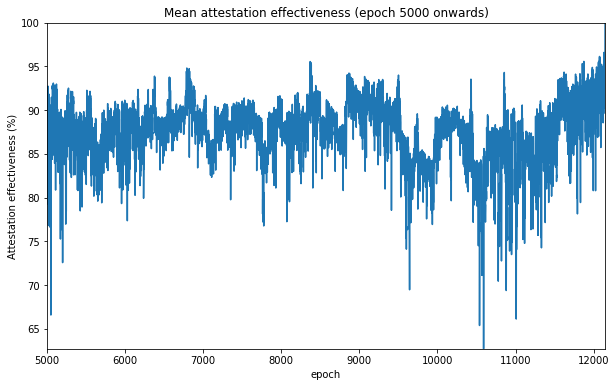

In [14]:
# graphs and stats for attestation effectiveness

mean_ae_series = pd.Series(mean_ae, name="mean attestation effectiveness")

print("Mean attestation effectiveness statistics\n")
print(mean_ae_series.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(10,6))
plt.plot(mean_ae_series)
plt.margins(0,0)
plt.title('Mean attestation effectiveness')
plt.xlabel('epoch')
plt.ylabel('Attestation effectiveness (%)')
plt.show()

print("Mean inclusion distance statistics (epoch 5000 onwards)\n")
print(mean_ae_series.iloc[5000:].describe())

# plot the mean inclusion distance
fig=plt.figure(figsize=(10,6))
plt.plot(mean_ae_series.iloc[5000:])
plt.margins(0,0)
plt.title('Mean attestation effectiveness (epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Attestation effectiveness (%)')
plt.show()

## Empty Slots and Orphaned Blocks
The data in the `chaind` database includes some *orphaned* (or equivalently *non-canonical*) blocks — i.e. blocks which were not finalised by the consensus process. Blocks may be orphaned when networking or other problems prevent them being visible to all nodes, accordingly they are yet another indicator of network health, as shown by the large increase in orphaned blocks around the roughtime incident.

In [15]:
# count orphaned blocks

cursor.execute("SELECT COUNT(*), SUM(f_canonical::int) FROM t_blocks;")
n_blocks, n_canonical = cursor.fetchone()
n_orphaned = n_blocks - n_canonical
print(f"Database contains {n_blocks} blocks of which {n_orphaned} ({100*(n_orphaned/n_blocks):.1f}%) orphaned")

Database contains 285155 blocks of which 8049 (2.8%) orphaned


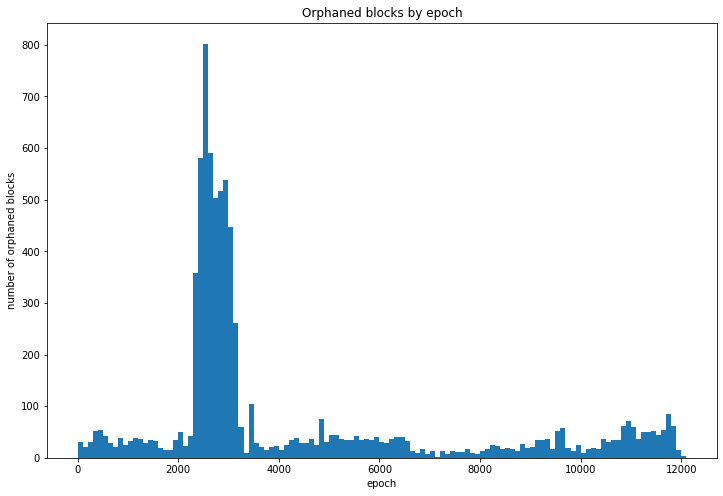

In [16]:
# plot empty slots and orphaned blocks by epoch

cursor.execute("SELECT f_slot FROM t_blocks WHERE f_canonical = true ORDER BY f_slot")
result = cursor.fetchall()
index = slot = 0
empty_slots = []
while slot < result[index]:

    
cursor.execute("SELECT f_slot FROM t_blocks WHERE f_canonical = false")
result = cursor.fetchall()
orphaned_slots_series = pd.Series([el[0] // 32 for el in result])
fig=plt.figure(figsize=(12,8))
orphaned_slots_series.plot.hist(bins=range(0,12200,100))
plt.title('Orphaned blocks by epoch')
plt.xlabel('epoch')
plt.ylabel('number of orphaned blocks')
plt.show()

## Activation delays
Finally, let's take a look at how quickly validators have managed to begin partipating once their respective `activation_epoch` is reached. Here interestingly the data shows that across the dataset, almost three quarters of validators successfully attested their first nominated slot. If this had been replicated at genesis, network finality would have been immediate. Looking at delays means considering only non-absent validators (i.e. validators who made no successful attestations in the entire dataset are excluded).

Validators who successfully attested first time have been excluded from the histogram below so we can look at those who were delayed (the bar at zero would otherwise completely dwarf the rest), and those who took more than 50 epochs have also been excluded (who make up around 10% of all non-absent validators).

Some interesting patterns appear in this data, but it seems sensible to try and break it down to see which may be genesis effects, and which persist after the chain has been running for some time.

Number of validators: 73258 (of which 100.0% activated of which 80.4% non-absent)
73.1% of non-absent validators attested successfully in their first active epoch.
9.8% of non-absent validators first attested more than 50 epochs late.

First attestation delay statistics for all live validators

count    16252.000000
mean       300.898166
std        682.286537
min          1.000000
25%          6.000000
50%         34.000000
75%        246.000000
max      11169.000000
Name: all, dtype: float64


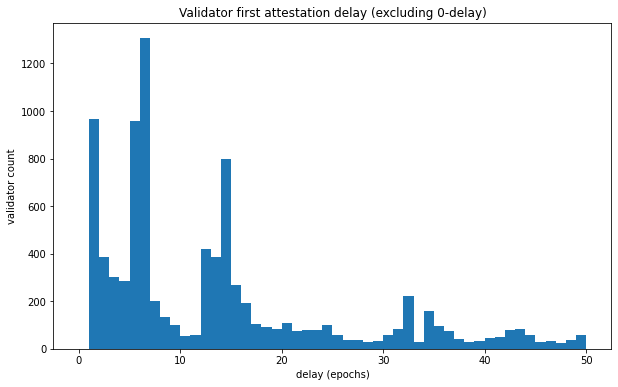

In [17]:
# validation delay
n_validators = len(validators)
n_activated = len([0 for _, v in validators.items() if v['activation_epoch'] < n_epochs])
n_live = len([0 for _, v in validators.items() if v['first_attestation'] != -1 and v['exit_epoch'] == -1])
n_prompt = len([0 for _, v in validators.items() if v['first_attestation'] // 32 == v['activation_epoch']])
n_late = len([0 for _, v in validators.items() if v['first_attestation'] // 32 - v['activation_epoch'] > 50])
print(f"Number of validators: {n_validators} (of which {100*n_activated/n_validators:.1f}% activated "
      f"of which {100*n_live/n_activated:.1f}% non-absent)\n{100*n_prompt/n_activated:.1f}% of non-absent validators "
      f"attested successfully in their first active epoch.\n"
      f"{100*n_late/n_activated:.1f}% of non-absent validators first attested more than 50 epochs late.\n")

all_delay = []
genesis_delay = []
post5000_delay = []
for _, validator in validators.items():
    delay = validator['first_attestation'] // 32 - validator['activation_epoch']
    if delay < 1:
      continue
    all_delay.append(delay)
    if validator['activation_epoch'] == 0:
        genesis_delay.append(delay)
    else:
        genesis_delay.append(None)
    if validator['activation_epoch'] >= 5000:
        post5000_delay.append(delay)
    else:
        post5000_delay.append(None)
        
delay_data = pd.DataFrame({'all':all_delay, 'genesis':genesis_delay, 'post5000':post5000_delay})

print('First attestation delay statistics for all live validators\n')
print(delay_data['all'].describe())

fig=plt.figure(figsize=(10,6))
delay_data['all'].plot.hist(bins=50, range=(0,50))
plt.title('Validator first attestation delay (excluding 0-delay)')
plt.xlabel('delay (epochs)')
plt.ylabel('validator count')
plt.show()

## Genesis and post-epoch-5000 activation delays
One of the issues observed at the launch of Medalla (and since repeated for the short-term Spadina testnet) is that it took some time for finality to be reached after the genesis slot. As shown in the data below, only 60% of genesis validators successfully attested in epoch 0. Interestingly also there seem to be spikes in attestation delay around epochs 6, 14 and 32.

If we look from block 5000 onwards the picture looks quite different. Almost 80% of these later validators attested successfully at the first opportunity, with the numbers of validators attesting late dropping off very rapidly.

Number of genesis validators: 20084 (of which 95.8% non-absent)
59.8% of non-absent genesis validators attested successfully in their first active epoch.
2.1% of non-absent genesis validators first attested more than 50 epochs late.

First attestation delay statistics for all live genesis validators

count     7234.000000
mean       126.811169
std        680.624323
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max      11169.000000
Name: genesis, dtype: float64


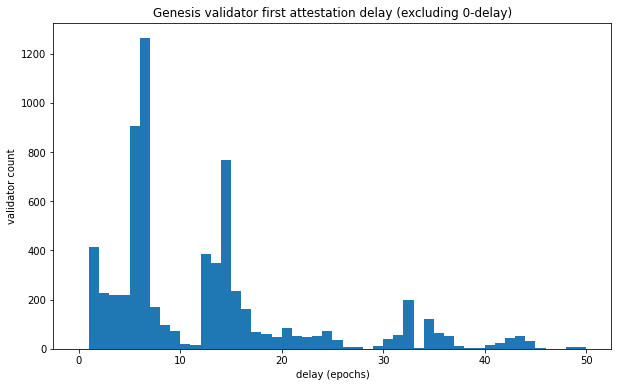

Number of validators activated from epoch 5000: 28604 (of which 96.6% non-absent)
83.4% of non-absent validators attested successfully in their first active epoch.
9.7% of non-absent validators first attested more than 50 epochs late.

First attestation delay statistics for all live validators activated since epoch 5000

count     7234.000000
mean       126.811169
std        680.624323
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max      11169.000000
Name: genesis, dtype: float64


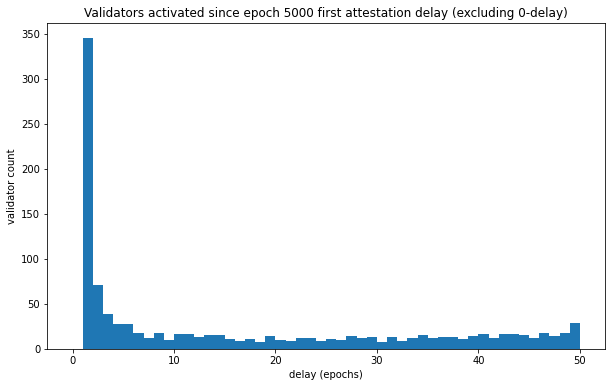

In [18]:
# validation delay - genesis validators and post-roughtime validators
n_genesis_validators = len([0 for _, v in validators.items() if v['activation_epoch'] == 0])
n_live = len([0 for _, v in validators.items() if v['activation_epoch'] == 0 and v['first_attestation'] != -1])
n_prompt = len([0 for _, v in validators.items() if v['first_attestation'] // 32 == 0])
n_late = len([0 for _, v in validators.items() if v['activation_epoch'] == 0 and v['first_attestation'] // 32 > 50])

print(f"Number of genesis validators: {n_genesis_validators} (of which {100*n_live/n_genesis_validators:.1f}% non-absent)\n"
      f"{100*n_prompt/n_genesis_validators:.1f}% of non-absent genesis validators attested successfully "
      f"in their first active epoch.\n"
      f"{100*n_late/n_genesis_validators:.1f}% of non-absent genesis validators first attested more than 50 epochs late.\n")
print('First attestation delay statistics for all live genesis validators\n')
print(delay_data['genesis'].describe())

fig=plt.figure(figsize=(10,6))
delay_data['genesis'].plot.hist(bins=50, range=(0,50))
plt.title('Genesis validator first attestation delay (excluding 0-delay)')
plt.xlabel('delay (epochs)')
plt.ylabel('validator count')
plt.show()

n_post5000_validators = len([0 for _, v in validators.items() if v['activation_epoch'] >= 5000])
n_live = len([0 for _, v in validators.items() if v['activation_epoch'] >= 5000 and v['first_attestation'] != -1])
n_prompt = len([0 for _, v in validators.items() if v['activation_epoch'] >= 5000 and v['first_attestation'] // 32 == v['activation_epoch']])
n_late = len([0 for _, v in validators.items() if v['activation_epoch'] >= 5000 and v['first_attestation'] // 32 - v['activation_epoch'] > 50])


print(f"Number of validators activated from epoch 5000: {n_post5000_validators} (of which {100*n_live/n_post5000_validators:.1f}% non-absent)\n"
      f"{100*n_prompt/n_post5000_validators:.1f}% of non-absent validators attested successfully "
      f"in their first active epoch.\n"
      f"{100*n_late/n_live:.1f}% of non-absent validators first attested more than 50 epochs late.\n")
print('First attestation delay statistics for all live validators activated since epoch 5000\n')
print(delay_data['genesis'].describe())

fig=plt.figure(figsize=(10,6))
delay_data['post5000'].plot.hist(bins=50, range=(0,50))
plt.title('Validators activated since epoch 5000 first attestation delay (excluding 0-delay)')
plt.xlabel('delay (epochs)')
plt.ylabel('validator count')
plt.show()

# Conclusions
Much of the analysis conducted so far rests on an important assumption — that validators who were dormant, absent or abandoned were so because the people responsible for them weren't properly incentivised. As a testnet with no value at stake, Medalla relies to a significant extent on participants acting non-maliciously, and on being reliable for the good of the network. This was always going to be a significant weakness of Medalla.

Without evidence to support an alternative explanation for this validator behaviour (such as significant numbers of users complaining they are unable to join or remain synchronised to the network), it seems reasonable to conclude that dormant/absent/abandoned validators are largely the result of apathy resulting from a lack of real-value incentivsiation. It therefore makes sense to try and exclude these types of validators from our analysis, since very few such validators would be expected to exist on a properly incentivised network.

With this in mind, this analysis seems to show that beacon chain protocol and the clients that implement it are able to achieve consistently high participation rates, which we should expect will be even higher once real value is on the line. It seems likely that this difference will be enough to push genesis participation up from 60% to the 66% required for immediate finality, but we do not have data that proves this, and indeed early problems on the Spadina testnet do not help us here. It's also important to remember that the beacon chain in its initial form does not support any data or execution shards, which will add additional load to the protocol in future.

Nonetheless, this data is encouraging from the perspective of demonstrating the feasability of a beacon chain under mainnet-like loads, at least in terms of numbers of validators, can run smoothly.

In [19]:
%store validators n_epochs latest_slot

Stored 'validators' (dict)
Stored 'n_epochs' (int)
Stored 'latest_slot' (int)
